In [56]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
import numpy as np
from tqdm import tqdm
import pandas as pd





In [57]:
train_df_all_features = pd.read_csv("data/processed_data/train.csv")

xgb_latitude = xgb.XGBRegressor()
xgb_longitude = xgb.XGBRegressor()

print(train_df_all_features.columns)

train_df_all_features["time_position_1_step_ago"].head()

Index(['time', 'cog', 'sog', 'rot', 'heading', 'navstat', 'etaRaw', 'latitude',
       'longitude', 'vesselId', 'portId', 'latitude_1_step_ago',
       'longitude_1_step_ago', 'time_position_1_step_ago',
       'latitude_2_steps_ago', 'longitude_2_steps_ago',
       'time_position_2_steps_ago', 'cog_1_step_ago', 'time_cog_1_step_ago',
       'cog_2_steps_ago', 'time_cog_2_steps_ago', 'week_of_the_year',
       'day_of_the_year', 'lat_change_2_to_1_steps', 'lon_change_2_to_1_steps',
       'avg_lat_change_1_step', 'avg_lat_change_2_steps',
       'avg_lon_change_1_step', 'avg_lon_change_2_steps', 'vesselType_14.0',
       'vesselType_21.0', 'vesselType_83.0', 'enginePower', 'CEU', 'GT',
       'breadth', 'length', 'DWT', 'maxSpeed'],
      dtype='object')


0         NaN
1    0.031663
2    0.031707
3    0.031757
4    0.031798
Name: time_position_1_step_ago, dtype: float64

In [58]:
lat_model_features =['time', 'cog', 'latitude_1_step_ago',
       'longitude_1_step_ago', 'time_position_1_step_ago',
       'latitude_2_steps_ago', 'longitude_2_steps_ago',
       'time_position_2_steps_ago', 'cog_1_step_ago', 'time_cog_1_step_ago',
       'cog_2_steps_ago', 'time_cog_2_steps_ago', 'week_of_the_year',
       'day_of_the_year', 'lat_change_2_to_1_steps', 'lon_change_2_to_1_steps',
       'avg_lat_change_1_step', 'avg_lat_change_2_steps',
       'avg_lon_change_1_step', 'avg_lon_change_2_steps', 'vesselType_14.0',
       'vesselType_21.0', 'vesselType_83.0', 'enginePower', 'CEU', 'GT',
       'breadth', 'length', 'DWT', 'maxSpeed']


In [65]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor

# Splitting the data for latitude and longitude predictions
train_X = train_df_all_features[lat_model_features]
train_y_lat = train_df_all_features["latitude"]
train_y_lng = train_df_all_features["longitude"]

# Splitting data into training and testing sets
X_train_lat, X_test_lat, y_train_lat, y_test_lat = train_test_split(train_X, train_y_lat, test_size=0.2, random_state=42)

# Defining XGBoost regressor with the best parameters for latitude and longitude
xgb_latitude_best_params = {'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 500}
xgb_longitude_best_params = {'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 500}

# Initializing the XGBoost models
xgb_latitude = XGBRegressor(**xgb_latitude_best_params)
xgb_longitude = XGBRegressor(**xgb_longitude_best_params)

# Train the model for latitude prediction
xgb_latitude.fit(X_train_lat, y_train_lat)
pred_lat = xgb_latitude.predict(X_test_lat)

# Convert predictions to a Pandas Series using the index from the test set
pred_lat_series = pd.Series(pred_lat, index=X_test_lat.index, name='predicted_latitude')

# Add predicted latitude values to the original training features
train_X_with_pred_lat = pd.concat([train_X, pred_lat_series], axis=1)

# Splitting the updated training data for longitude prediction
X_train_lng, X_test_lng, y_train_lng, y_test_lng = train_test_split(train_X_with_pred_lat, train_y_lng, test_size=0.2, random_state=42)

# Train the model for longitude prediction
xgb_longitude.fit(X_train_lng, y_train_lng)
pred_lon = xgb_longitude.predict(X_test_lng)

# Calculate RMSE for both latitude and longitude predictions
rmse_latitude = root_mean_squared_error(y_test_lat, pred_lat)
rmse_longitude = root_mean_squared_error(y_test_lng, pred_lon)

print(f"Test data RMSE for Latitude: {rmse_latitude}")
print(f"Test data RMSE for Longitude: {rmse_longitude}")

Test data RMSE for Latitude: 1.2068643886023789
Test data RMSE for Longitude: 3.5566124074727887


In [59]:
# TRAINING AND TESTING ON ALL DATA

train_X_lat = train_df_all_features[lat_model_features]
train_y_lat = train_df_all_features["latitude"]
train_y_lng = train_df_all_features["longitude"]


xgb_latitude_best_params = {'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 500}
xgb_longitude_best_params = {'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 500}


xgb_latitude.set_params(**xgb_latitude_best_params)
xgb_longitude.set_params(**xgb_longitude_best_params)


# Train the model for latitude
xgb_latitude.fit(train_X_lat, train_y_lat)
pred_lat = xgb_latitude.predict(train_X_lat)
pred_lat_series = pd.Series(pred_lat, index=train_X_lat.index, name='predicted_latitude')


train_X_lng = pd.concat([train_X_lat, pred_lat_series],axis=1)

# Train the model for longitude
xgb_longitude.fit(train_X_lng, train_y_lng)
pred_lon = xgb_longitude.predict(train_X_lng)



# Evaluate performance using Mean Squared Error (MSE)
rmse_latitude = root_mean_squared_error(train_y_lat, pred_lat)
rmse_longitude = root_mean_squared_error(train_y_lng, pred_lon)

print(f"Train data RMSE for Latitude: {rmse_latitude}")
print(f"Train data RMSE for Longitude: {rmse_longitude}")

#Train data RMSE for Latitude: 0.13254262539922262
#Train data RMSE for Longitude: 0.13761807097128528

Train data RMSE for Latitude: 0.13254262539922262
Train data RMSE for Longitude: 0.13761807097128528


<Figure size 1000x600 with 0 Axes>

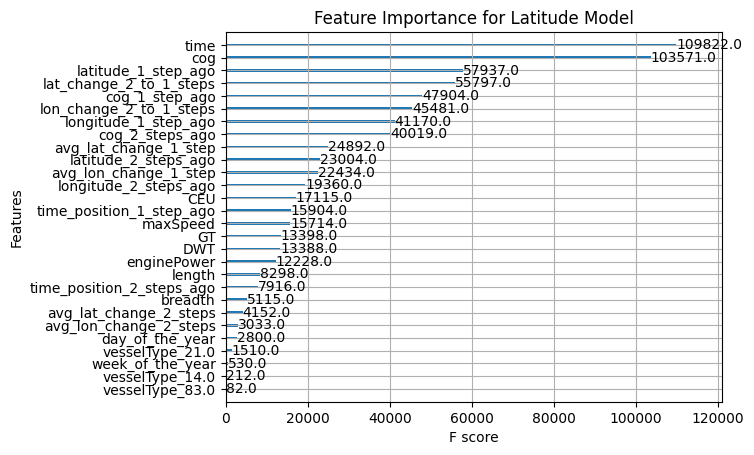

<Figure size 1000x600 with 0 Axes>

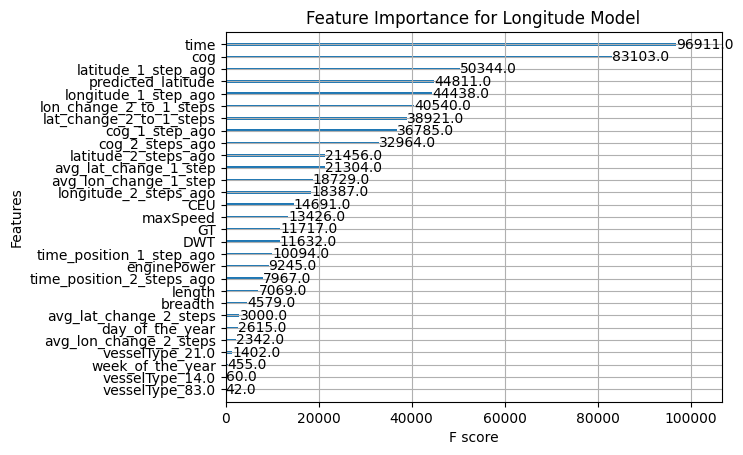

In [23]:
import matplotlib.pyplot as plt

# Plot feature importance for the Latitude model
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_latitude, importance_type='weight', title="Feature Importance for Latitude Model")
plt.show()

# Plot feature importance for the Longitude model
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_longitude, importance_type='weight', title="Feature Importance for Longitude Model")
plt.show()

In [51]:
test_df_all_features = pd.read_csv("data/processed_data/test.csv")

test_df_all_features.columns

Index(['ID', 'vesselId', 'time', 'scaling_factor', 'week_of_the_year',
       'day_of_the_year', 'avg_lat_change_1_step', 'avg_lat_change_2_steps',
       'avg_lon_change_1_step', 'avg_lon_change_2_steps', 'vesselType_14.0',
       'vesselType_21.0', 'vesselType_83.0', 'enginePower', 'CEU', 'GT',
       'breadth', 'length', 'DWT', 'maxSpeed'],
      dtype='object')

In [52]:
test_X = test_df_all_features[['vesselId', 'ID', 'time', 'week_of_the_year',
       'day_of_the_year', 'avg_lat_change_1_step', 'avg_lat_change_2_steps',
       'avg_lon_change_1_step', 'avg_lon_change_2_steps', 'vesselType_14.0',
       'vesselType_21.0', 'vesselType_83.0', 'enginePower', 'CEU', 'GT',
       'breadth', 'length', 'DWT', 'maxSpeed']]

In [53]:
for col in lat_model_features:
    if col not in test_X.columns:
        test_X[col] = np.nan

train_df = train_df_all_features.sort_values(by=['vesselId', 'time'])

last_known_positions = train_df.groupby('vesselId').agg({
    'cog': 'last',
    'cog_1_step_ago': 'last',
    'time_cog_1_step_ago': 'last',
    'cog_2_steps_ago': 'last',
    'time_cog_2_steps_ago': 'last',
    'latitude_1_step_ago': 'last',
    'longitude_1_step_ago': 'last',
    'time_position_1_step_ago': 'last',
    'latitude_2_steps_ago': 'last',
    'longitude_2_steps_ago': 'last',
    'time_position_2_steps_ago': 'last',
    "lat_change_2_to_1_steps": 'last',
    "lon_change_2_to_1_steps": 'last',
    "latitude": 'last',
    "longitude": 'last',
    "time": 'last',
}).reset_index()

last_known_dict = last_known_positions.set_index('vesselId').to_dict('index')
results_list = []
unique_vessel_ids = test_df_all_features["vesselId"].unique()

last_known_dict.get("clh6aqawa0007gh0z9h6zi9bo")

{'cog': 0.1493036211699164,
 'cog_1_step_ago': 0.1465181058495821,
 'time_cog_1_step_ago': 0.3496854444950414,
 'cog_2_steps_ago': 0.9930362116991645,
 'time_cog_2_steps_ago': 0.3496468958712811,
 'latitude_1_step_ago': 59.83316,
 'longitude_1_step_ago': 21.38489,
 'time_position_1_step_ago': 0.3496854444950414,
 'latitude_2_steps_ago': 59.76388,
 'longitude_2_steps_ago': 21.35317,
 'time_position_2_steps_ago': 0.3496468958712811,
 'lat_change_2_to_1_steps': 0.0692799999999991,
 'lon_change_2_to_1_steps': 0.0317199999999999,
 'latitude': 59.89167,
 'longitude': 21.54685,
 'time': 0.3497249101902449}

In [54]:
import joblib

cog_model = joblib.load('processors/cog_model.pkl')

cog_model_expected_features = ['time', 'latitude_1_step_ago',
       'longitude_1_step_ago', 'latitude_2_steps_ago', 'longitude_2_steps_ago',
       'cog_1_step_ago', 'cog_2_steps_ago', 'week_of_the_year',
       'day_of_the_year', 'lat_change_2_to_1_steps', 'lon_change_2_to_1_steps',
       'avg_lat_change_1_step', 'avg_lat_change_2_steps',
       'avg_lon_change_1_step', 'avg_lon_change_2_steps',]

In [55]:



with tqdm(total=len(test_X), unit="row", desc="Making Predictions") as pbar:

    for vessel_id in unique_vessel_ids:
        df = test_X[test_X["vesselId"] == vessel_id].reset_index(drop=True)

        df = df.sort_values(by=['time'])

        for row in df.itertuples(index=True):
            vessel_ID = row.vesselId
            row_ID = row.ID
            current_time = row.time

            last_entry = last_known_dict.get(vessel_ID)

            if last_entry == None:
                raise ValueError("Last entry not found")
            
            #print(f"Dict entry of vessels prev row: {last_known_dict.get(vessel_ID)}")
            # Data for CURRENT STEP
            latitude_1_step_ago = last_entry['latitude']
            longitude_1_step_ago = last_entry['longitude']
            time_position_1_step_ago = last_entry['time']
            latitude_2_steps_ago = last_entry['latitude_1_step_ago']
            longitude_2_steps_ago = last_entry['longitude_1_step_ago']
            time_position_2_steps_ago = last_entry['time_position_1_step_ago']
            lat_change_2_to_1_steps = latitude_1_step_ago - latitude_2_steps_ago
            lon_change_2_to_1_steps = longitude_1_step_ago - longitude_2_steps_ago
            cog_1_step_ago = last_entry["cog"]
            time_cog_1_step_ago = last_entry["time"]
            cog_2_steps_ago = last_entry["cog_1_step_ago"]
            time_cog_2_steps_ago = last_entry["time_cog_1_step_ago"]



            # Assign last known positions from training data
            test_X.at[row.Index, "latitude_1_step_ago"] = latitude_1_step_ago
            test_X.at[row.Index, "longitude_1_step_ago"] = longitude_1_step_ago
            test_X.at[row.Index, "time_position_1_step_ago"] = time_position_1_step_ago
            test_X.at[row.Index, "latitude_2_steps_ago"] = latitude_2_steps_ago
            test_X.at[row.Index, "longitude_2_steps_ago"] = longitude_2_steps_ago
            test_X.at[row.Index, "time_position_2_steps_ago"] = time_position_2_steps_ago
            test_X.at[row.Index, "lat_change_2_to_1_steps"] = lat_change_2_to_1_steps
            test_X.at[row.Index, "lon_change_2_to_1_steps"] = lon_change_2_to_1_steps
            test_X.at[row.Index, "cog_1_step_ago"] = cog_1_step_ago
            test_X.at[row.Index, "time_cog_1_step_ago"] = time_cog_1_step_ago
            test_X.at[row.Index, "cog_2_steps_ago"] = cog_2_steps_ago
            test_X.at[row.Index, "time_cog_2_steps_ago"] = time_cog_2_steps_ago



            # Make predictions
            feature_vector = test_X.loc[row.Index, cog_model_expected_features].to_frame().T
            feature_vector = feature_vector.apply(pd.to_numeric, errors='coerce')

            pred_cog = cog_model.predict(feature_vector)[0]

            feature_vector = test_X.loc[row.Index, lat_model_features].to_frame().T
            feature_vector = feature_vector.apply(pd.to_numeric, errors='coerce')

            feature_vector['cog'] = pred_cog

            pred_lat = xgb_latitude.predict(feature_vector)[0]

            feature_vector['predicted_latitude'] = pred_lat

            pred_lon = xgb_longitude.predict(feature_vector)[0]


            results_list.append({
                "ID": row_ID,
                "latitude_predicted": pred_lat,
                "longitude_predicted": pred_lon,
            })

            last_known_dict[vessel_ID] = {
                'latitude_1_step_ago': latitude_1_step_ago,
                'longitude_1_step_ago': longitude_1_step_ago,
                'time_position_1_step_ago': time_position_1_step_ago,
                'latitude_2_steps_ago': latitude_2_steps_ago,
                'longitude_2_steps_ago': longitude_2_steps_ago,
                'time_position_2_steps_ago': time_position_2_steps_ago,
                "lat_change_2_to_1_steps": lat_change_2_to_1_steps,
                "lon_change_2_to_1_steps": lon_change_2_to_1_steps,
                "latitude": pred_lat,
                "longitude": pred_lon,
                "time": current_time,
                "cog_1_step_ago": cog_1_step_ago,
                "time_cog_1_step_ago": time_cog_1_step_ago,
                "cog_2_steps_ago": cog_2_steps_ago,
                "time_cog_2_steps_ago": cog_2_steps_ago,
                "cog": pred_cog,
            }
                
            


            pbar.update(1)
            #print(f"Row: {test_X.iloc[row.Index]}")
            #print(f"Pred lat: {pred_lat}, Pred long: {pred_lon}")
            #print(f"Dict entry of vessel: {last_known_dict.get(vessel_ID)}")

# Convert the results list to a DataFrame and sort by ID
results = pd.DataFrame(results_list).sort_values(by=['ID'])

# Save predictions to CSV
results.to_csv("data/v4.csv", index=False)
                
             


            


Making Predictions: 100%|██████████| 51739/51739 [05:02<00:00, 171.04row/s]
